In [23]:
import re
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np

In [24]:
# wall power
raw = 6.5
raw_load = 13.5
ldst = 12.1
ldst_flush = 12.8
ld_flush = 12.7
ld = 12.8
noamx_cpu100 = 15.7

cpu_max_powermetric = 4
cpu_35_powermetric = cpu_max_powermetric * 0.35

In [27]:
amx_impact = 0
all_impact = 0
impact_pct = 0
cpu_freq = 0
cpu_power = 0
amx_avg_power = 0
i = 0
d = OrderedDict()

with open('power.txt', 'r+') as f:
	for line in f:
		if re.search(r"Sampled system activity.*\*\*\*", line):
			i += float(re.findall(r'\d+.\d+', line)[-1])
		if re.search(r"amx_power +\d+.*", line):
			amx_impact = float(re.findall(r'\d+\.\d+', line)[-1])
			# if amx_impact > 1500:
			# 	amx_impact = 0
		if re.search(r"ALL_TASKS +.*\d+.*", line):
			all_impact = float(re.findall(r'\d+\.\d+', line)[-1])
		if re.search(r"P1-Cluster HW active frequency: \d+ MHz", line):
			cpu_freq = float(re.findall(r'\d+', line)[-1]) / 1000
		if re.search(r"CPU Power: \d+ mW", line):
			cpu_power = float(re.findall(r'\d+', line)[-1]) / 1000
		if all_impact and cpu_freq and cpu_power:
			impact_pct = amx_impact / all_impact
			d[i] = {"impact": impact_pct, 
	       				"freq": cpu_freq, 
						"power": cpu_power}
			# print(amx_impact)
			amx_impact = 0
			all_impact = 0
			cpu_freq = 0
			cpu_power = 0

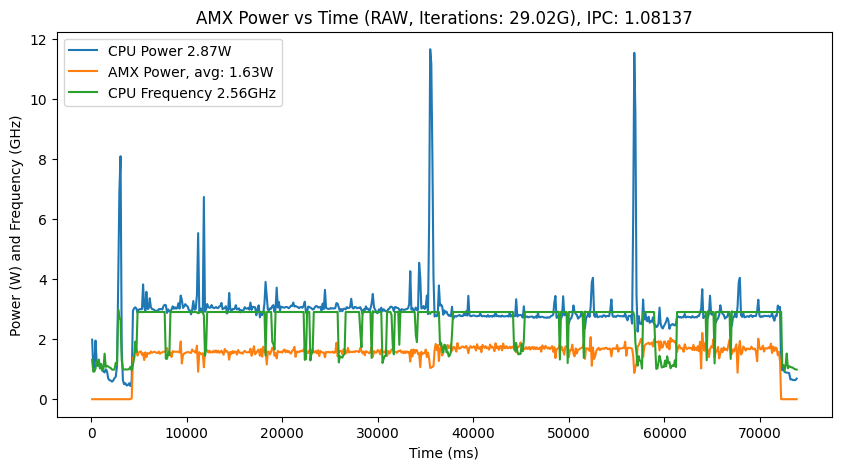

In [28]:
x = list(d.keys())
iters = 290232 * 100000 / 1e9

plt.figure(figsize=(10, 5))
total_power = np.array([val['power'] for val in d.values()])
freq = np.array([val['freq'] for val in d.values()])
amx_power = total_power * np.array([val['impact'] for val in d.values()])
amx_avg_power = np.mean([i for i in amx_power if i != 0])
plt.plot(x, total_power, label='CPU Power {:.2f}W'.format(np.mean(total_power)))
plt.plot(x, amx_power, label='AMX Power, avg: {:.2f}W'.format(amx_avg_power))
plt.plot(x, freq, label='CPU Frequency {:.2f}GHz'.format(np.mean(freq)))
plt.xlabel('Time (ms)')
plt.ylabel('Power (W) and Frequency (GHz)')

ipc = iters / (np.max(x)-5000) * 1000 * np.mean(freq)
plt.title('AMX Power vs Time (RAW, Iterations: {:.2f}G), IPC: {:.5f}'.format(iters, ipc))
plt.legend()